In [ ]:
# MIT License
#
# @title Copyright (c) 2025 Mauricio Tec { display-mode: "form" }

# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.


# Welcome to the HDSI Winter Workshop on LLMs as Autonomous Agents


<img src="https://drive.google.com/uc?export=view&id=1q4SGPmn6sWQhskt4D-1D09q_6C9FDz_L" alt="drawing" width="400"/>


# **Part II: Grounding Agents with Fine-tuning and RL**

<a target="_blank" href="https://colab.research.google.com/github/mauriciogtec/hdsi-winter-workshop/blob/main/llm-agents-part2.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Expected completion time: 1:30 hours | Recommended Compute: GPU 15GB RAM + CPU 8GB RAM


## March 7, 2025  <br> Mauricio Tec



**TL;DR** Our previous tutorial gave us the tools to understand agentic LLM workflows. In this tutorial we will talk about learning. We will use fine tuning and reinforcement learning to improve the LLM for specific tasks.

🔥🔥 📚 **Let's learn how to learn** 📚🔥🔥

*Familiarity with PyTorch models is assumed.*


<br>


<img src="https://drive.google.com/uc?export=view&id=1e3nRrx9IT5BjhWFwk1VKHS-a6m0EoMhc" alt="drawing" width="450"/>


See also:

* [Previous (Part I): Introduction to Agentic Frameworks](https://colab.research.google.com/github/mauriciogtec/hdsi-winter-workshop/blob/main/llm-agents-part1.ipynb)
* [Pre-assignment: Setup LLM Access & API Keys](https://colab.research.google.com/github/mauriciogtec/hdsi-winter-workshop/blob/main/pre-assignment.ipynb)


# Software Prerequisites & Setup


## Utility Function: Markdown Printing

As in part I, we will define a very simple utility function to print nicely in a colab notebook environment with Markdown. This is not really needed, but it will make some output visualizations easier and nicer.


In [ ]:
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

test = "`This is code`. *This is italics*. **This is bold**."
printmd(test)

`This is code`. *This is italics*. **This is bold**.

## Mount Google Colab
While not needed, this will help us to save outputs and checkpoints

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

# Create a target dir to save files
target_dir = '/content/drive/MyDrive/hdsi-winter-workshop/'
os.makedirs(target_dir, exist_ok=True)

Mounted at /content/drive


## Install Requirements

* The main tool will be `PyTorch`, which is the most common deep learning research framework.

<img src="https://upload.wikimedia.org/wikipedia/commons/9/96/Pytorch_logo.png" alt="drawing" width="300"/>


* Our second main tool, more specific to this tutorial, is the  `transformers` library, which provides access to various open-source `LLMs` as PyTorch. With transformers we have access to their internals, code, and weights.
* The `HuggingFace` tool ecosystem includes various other packages that we will need to be able to manipulate such massive models, which go beyond standard neural network training. Examples include `peft`, `bitsandbytes`, `accelerate`. For reinforcement learning and finetuning, we will use the `trl` library, which includes functionality for finetuning.
* Lastly, we will continue using the `smolagents` library for implementing the basic react loop functionality.

<img src="https://drive.google.com/uc?export=view&id=1RGuWtGHW88vk7T5JyMjnepG9YzwKJEVM" alt="drawing" width="600"/>


* 🎮 Let's play a game! While the techniques we will study apply to many environments. We will base our tutorial one nice text-based game called `TextWorld`.  

<img src="https://drive.google.com/uc?export=view&id=1fdfrUd4gxsute0b6qRdZ5d6l4y16D6UK" alt="drawing" width="600"/>


In [ ]:
%pip install -q -U \
  transformers[torch,accelerate] \
  trl[peft] \
  bitsandbytes \
  textworld-express

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 🤗 The HuggingFace Transformer Model 🤗

We will be working with the `meta-llama/Llama-3.2-1B-Instruct` model. Let us check access.

If your access is restricted, check out the [pre-assignment notebook](https://colab.research.google.com/github/mauriciogtec/hdsi-winter-workshop/blob/main/pre-assignment.ipynb) for more details on setting up access to Llama 3.2 on HuggingFace.


In [ ]:
# Retrieve open AI key from Colab secrets
import os
from google.colab import userdata
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

In [ ]:
# @title Test HF Model

import transformers
import peft
import torch

# Change logging of transformer to avoid so many warnings
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

model_id = "meta-llama/Llama-3.2-1B-Instruct"
# You can also try the 3B model, But you'll need a slightly larger GPU than the T4 entry-level Colab one

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    # quantization_config=transformers.BitsAndBytesConfig(load_in_8bit=True),
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    device_map="auto",
    use_cache=True,
)

tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)

# Some info about the model
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters in LLM: {num_params:,}")

# compute bytes in memory of model
obj_mem  = model.get_memory_footprint()
obj_mem_gb = obj_mem / (1024**3)
print(f"Memory footprint of model: {obj_mem_gb:.2f} gigabytes")


# Utility to generate text
def call_model(prompt, model, verbose=False, **kwargs):
    """Simple function to call the model."""
    # First empty cache
    torch.cuda.empty_cache()

    # Get model device
    device = next(model.parameters()).device

    # First convert to conversational form and use the chat tempalte
    messages= [{"role": "user", "content": prompt}]

    # Tokenize
    full_prompt = tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
    inputs = tokenizer(full_prompt, return_tensors="pt").to(device)

    if verbose:
        print(f"== Prompt after applying chat template:\n{full_prompt}")
        print(f"== Tokenized prompt ==\n{inputs.input_ids}")

    # Generate
    with torch.no_grad():
        gen = model.generate(
            **inputs,
            max_new_tokens=100,
            eos_token_id=tokenizer.eos_token_id,
            **kwargs,
        )[0]

    # Remove generation tokens
    num_inputs = len(inputs["input_ids"][0])
    gen = gen[num_inputs:]

    if verbose:
        print(f"== Generated tokens ==\n{gen}")

    # Decode to text
    result = tokenizer.decode(gen, skip_special_tokens=True)

    if verbose:
        print(f"== Decoded text ==\n{result}")

    return result

call_model("What is the capital of France?", model, verbose=True);

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Number of parameters in LLM: 1,235,814,400
Memory footprint of model: 2.30 gigabytes
== Prompt after applying chat template:
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 07 Mar 2025

<|eot_id|><|start_header_id|>user<|end_header_id|>

What is the capital of France?<|eot_id|><|start_header_id|>assistant<|end_header_id|>


== Tokenized prompt ==
tensor([[128000, 128000, 128006,   9125, 128007,    271,  38766,   1303,  33025,
           2696,     25,   6790,    220,   2366,     18,    198,  15724,   2696,
             25,    220,   2589,   2947,    220,   2366,     20,    271, 128009,
         128006,    882, 128007,    271,   3923,    374,    279,   6864,    315,
           9822,     30, 128009, 128006,  78191, 128007,    271]],
       device='cuda:0')
== Generated tokens ==
tensor([   791,   6864,    315,   9822,    374,  12366,     13, 128009],
       device='cuda:0')
== Decoded text ==
The capital of France is Paris.


## 🎮 The TextWorld Interactive Environment 🎮

Let's start the fun 🤩. We will play the`twc` (TextWorld common sense) games. There is the documentation's description of the game:

> `TextWorld Common Sense (twc)`

> Text game agents frequently learn the dynamics of environment --
such as the need to open a door before one can move through it --
from interacting with the environment itself, rather than using a pre-existing
knowledge base of common sense facts or object affordances that would speed
task learning. TextWorld Commonsense [Murugesan etal., 2021](https://arxiv.org/abs/2010.03790)
aims to evaluate agents on common sense knowledge that can not be directly learned from the
environment by providing agents a clean-up task where the agent must place
common household objects (e.g., a dirty dish) in their canonical locations
(e.g., the dishwasher) that can be found in knowledge bases such as ConceptNet.
Separate lists of objects are used in the training, development, and test sets,
meaning the agent can not learn object locations from the training set alone,
and must rely on an external common sense knowledge base to perform well on the
development and test sets. TextWorld Commonsense benchmark has three task
difficulty levels, with the easiest including a single location and object to
put away, while the hard setting includes up to p to 11 locations and any number
of task-relevant and distractor objects.

In [ ]:
import random
from textworld_express import TextWorldExpressEnv


#  Textworld game Engine Creator
def env_factory(
    gameName: str = "twc",
    gameParams: str = "numLocations=3,includeDoors=1,numItemsToPutAway=4",
    time_limit: int = 12,
    gold_path: bool = False,
):
    env = TextWorldExpressEnv(envStepLimit=time_limit)
    env.load(gameName=gameName, gameParams=gameParams)
    return env

# Create new game instance
env = env_factory()
obs, infos = env.reset(seed=1234, gameFold="train")


# Take some random steps and collect experience in history
history = []
history.append("## Welcome to TextWorld")
history.append(f"`<Task>`: {env.getTaskDescription()}")
history.append(f"`<Starting Obs>`: {obs}")

for step_id in range(10):
    history.append(f"**Step {step_id + 1}**")

    # Select a random valid action
    randomAction = random.choice(infos['validActions'])

    # Take that action
    obs, reward, done, infos = env.step(randomAction)

    # Display action and the game's feedback.
    history.append(f"`<Valid Actions>` {infos['validActions']}")
    history.append(f"`<Action>` {randomAction}")
    history.append(f"`<Obs>` {obs}")
    history.append(f"`<Reward>` {reward:0.2f}")

history = "\n\n".join(history)
printmd(history)

## Welcome to TextWorld

`<Task>`: Your task is to pick up objects, then place them in their usual locations in the environment.

`<Starting Obs>`: You are in the pantry. In one part of the room you see a folding chair, that has nothing on it. There is also a shelf, that has nothing on it. You also see a clean plate. 
To the East you see a closed plain door. 

**Step 1**

`<Valid Actions>` ['move east', 'close door to east', 'open door to east', 'look around', 'inventory', 'take clean plate']

`<Action>` look around

`<Obs>` You are in the pantry. In one part of the room you see a folding chair, that has nothing on it. There is also a shelf, that has nothing on it. You also see a clean plate. 
To the East you see a closed plain door. 

`<Reward>` 0.00

**Step 2**

`<Valid Actions>` ['look around', 'close door to east', 'open door to east', 'inventory', 'move east', 'take clean plate']

`<Action>` move east

`<Obs>` You can't move there, the door is closed. 

`<Reward>` 0.00

**Step 3**

`<Valid Actions>` ['inventory', 'open door to east', 'take clean plate', 'look around', 'close door to east', 'move east']

`<Action>` look around

`<Obs>` You are in the pantry. In one part of the room you see a folding chair, that has nothing on it. There is also a shelf, that has nothing on it. You also see a clean plate. 
To the East you see a closed plain door. 

`<Reward>` 0.00

**Step 4**

`<Valid Actions>` ['take clean plate', 'close door to east', 'move east', 'look around', 'open door to east', 'inventory']

`<Action>` inventory

`<Obs>` Inventory: 
  Your inventory is currently empty.


`<Reward>` 0.00

**Step 5**

`<Valid Actions>` ['inventory', 'move east', 'take clean plate', 'look around', 'open door to east', 'close door to east']

`<Action>` look around

`<Obs>` You are in the pantry. In one part of the room you see a folding chair, that has nothing on it. There is also a shelf, that has nothing on it. You also see a clean plate. 
To the East you see a closed plain door. 

`<Reward>` 0.00

**Step 6**

`<Valid Actions>` ['open door to east', 'inventory', 'move east', 'close door to east', 'look around', 'take clean plate']

`<Action>` move east

`<Obs>` You can't move there, the door is closed. 

`<Reward>` 0.00

**Step 7**

`<Valid Actions>` ['open door to east', 'take clean plate', 'inventory', 'close door to east', 'look around', 'move east']

`<Action>` inventory

`<Obs>` Inventory: 
  Your inventory is currently empty.


`<Reward>` 0.00

**Step 8**

`<Valid Actions>` ['close door to east', 'open door to east', 'take clean plate', 'inventory', 'look around', 'move east']

`<Action>` open door to east

`<Obs>` You open the plain door, revealing the kitchen. 

`<Reward>` 0.00

**Step 9**

`<Valid Actions>` ['move east', 'put clean plate in folding chair', 'look around', 'open door to east', 'put clean plate in shelf', 'close door to east', 'inventory']

`<Action>` take clean plate

`<Obs>` You take the clean plate.

`<Reward>` 0.12

**Step 10**

`<Valid Actions>` ['put clean plate in folding chair', 'look around', 'close door to east', 'open door to east', 'inventory', 'move east', 'put clean plate in shelf']

`<Action>` open door to east

`<Obs>` That is already open. 

`<Reward>` 0.00

# I. Benchmarking the Baseline Agents

Using what we learned in the previous part, let's evaluate how well the basic and chain of thought agents perform in TextWorld.


### Building Functionality: Creating the Planning and Action Steps

We will now implement some utility functions that will allow the agent to play the game.

#### *Coding Plan*

* 📜 **Build the task prompt** – Use `build_task_prompt(history, valid_actions)` to construct the task prompt, incorporating history and valid actions.
* 📝 **Generate a plan** – Use `planning_step(task_prompt, previous_plan=None)` to create an initial plan and revise it as new observations are made.
* 🤖 **Select the next action** – Use `action_step(task_prompt, valid_actions, example_thoughts=None)` to determine the next valid action, optionally incorporating a thought process.
* 🎯 **Ensure valid actions** – Use `extract_valid_action(response, valid_actions)` to validate and correct actions based on the valid action list.

In [ ]:
def build_task_prompt(memory):
    """Builds the task prompt from memory, including examples."""
    return "\n\n".join(memory) + "Answer the questions below. Give all answers using plain text or bullet points. Don't use hastags `#`. Prefer short answers."


def planning_step(model, task_prompt, previous_plan=None):
    """Generates a plan."""
    plan_prompt = task_prompt + "### Question\nOutline a plan to solve the task.\n"

    return call_model(plan_prompt, model)


def action_step(model, task_prompt, valid_actions, thinking=False):
    """Generates an action. If example thoughts are provided, it first generates thoughts before selecting an action."""

    # Use chain of thought if needed
    if thinking:
        thought_prompt = task_prompt + (
            "\n\n###Question\nLet's think step by step before deciding the best next action.\n"
            f"The valid actions are: {','.join(valid_actions)}\n"
            "\n\n###Example:\nMy task is to move misplaced objects to their usual locations. I just arrived to the kitchen and my inventory has a kitchen knife. Then, I must drop the kitcken knife here.\n"
        )
        thoughts = call_model(thought_prompt, model)
        task_prompt += f"\n\n[Thoughts] {thoughts}"
    else:
        thoughts = ""

    # Obtain action, ensuring validity
    task_prompt += (
        "\n\nNow, choose exactly one valid action from the list and no additional information.\n"
         f"The valid actions are: {','.join(valid_actions)}\n"
         f"Example answer: {random.choice(valid_actions)}"
    )
    response = call_model(task_prompt, model).strip()
    for chars in ["[", "]", "`", '"', "'", "\n", ":"]:
        response = response.replace(chars, "")
    action = extract_valid_action(model, response, valid_actions)

    return action, thoughts


def extract_valid_action(model, response, valid_actions):
    """Ensures the extracted action is valid, querying the LLM if needed."""
    action = response.strip("[]`:").strip()
    if action in valid_actions:
        return action

    correction_prompt = (
        f"The agent responded: '{response}'. However, this is not a valid action.\n"
        f"The valid action list is {valid_actions}, extract the closest correct action.\n"
        "If the response contains unnecessary words like 'You move north to take the ball.', extract only 'move north'.\n"
        "If multiple optimal actions where suggested, choose the first valid action.\n"
        "Example corrections:\n"
        "- You open the cabinet.' → open shoe cabinet\n"
        "- 'Check my bag.' → inventory\n"
        "- Move in the east direction to take pick up shows and go west.' → move east\n"
        "- move south move north → move south\n"
        "- move north, pick up shoes → move north\n"
        "- pick up shoes, move north → pick up shoes\n"
        "Return only the corrected action from the valid action list without extra words.\n"
        "For instance, in the last example, your answer should simply be: pick up shoes"
    )
    corrected_action = call_model(correction_prompt, model).strip()
    return corrected_action

Let's now test these function in a single decision step.

In [ ]:
# Initialize environment
env = env_factory()
obs, infos = env.reset(gameFold="train")

# Initialize memory
valid_actions = infos['validActions']
memory = [
    "## Welcome to TextWorld",
    f"`[Task]`: {env.getTaskDescription()}",
    f"`[Starting Obs]`: {obs}",
    f"`[Valid Actions]`: {valid_actions}",
]

# Initialize prompt
task_prompt = build_task_prompt(memory)

# # Start decision making
# plan = planning_step(model, task_prompt)
# memory.append(f"`[Initial Plan]` {plan}")

action, thoughts = action_step(model, task_prompt, valid_actions, thinking=True)

obs, reward, done, infos = env.step(action)

memory.append(f"`[Thoughts]` {thoughts}")
memory.append(f"`[Action]` {action}")
memory.append(f"`[Obs]` {obs}")
memory.append(f"`[Reward]` {reward:0.2f}")

printmd("\n\n".join(memory))

## Welcome to TextWorld

`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.

`[Starting Obs]`: You are in the bedroom. In one part of the room you see a dressing table, that has nothing on it. There is also a desk chair, that has nothing on it. You also see a desk, that has nothing on it. In another part of the room you see a chest of drawers that is closed. In one part of the room you see a wardrobe that is closed. There is also a night stand, that has nothing on it. You also see a bed, that has nothing on it. In another part of the room you see a black duvet. 
To the North you see a closed wood door. 

`[Valid Actions]`: ['look around', 'take black duvet', 'open door to north', 'close door to north', 'open wardrobe', 'inventory', 'move north', 'open chest of drawers']

`[Thoughts]` Here are the possible actions:

• look around
• take black duvet
• open door to north
• close door to north
• open wardrobe
• inventory
• move north
• open chest of drawers

`[Action]` open chest of drawers

`[Obs]` You open the chest of drawers. It's empty inside.

`[Reward]` 0.00

### Playing a Full Episode

Let's put together our functions we created above into a "rollout" loop to play a full episode.

*Coding Plan*

* 👾 The game engine must be initiated
* 📖 We ask the agent for an initial plan, and revise it so often.
* 📈 We need to keep adding observations and actions to the memory
* 💸 We need to track the total reward of the agent
* 📀 At each step, we ask the agent for the action to take using the functions we just created in the previous step.


In [ ]:
from datetime import datetime # to include time in loop
from typing import Literal  # hint valid arguments to a function
from tqdm.auto import tqdm  # progress bar


def episode_rollout(
    model: transformers.PreTrainedModel,
    gameFold: str = Literal["train", "valditation", "test"],
    thinking: bool = False,
    planning: bool = False,
    planning_interval: int = 3,
    env_factory_options: dict = {},
    seed: int = None
):
    # Set model in eval mode, no dropout, etc..)
    model.eval()

    # Initialize env
    env = env_factory(**env_factory_options)
    obs, infos = env.reset(gameFold=gameFold, seed=seed)

    # Initialize Memory
    memory = []
    memory.append(f"`[Task]`: {env.getTaskDescription()}")
    memory.append(f"`[Starting Obs]`: {obs}")


    # Make task prompt
    task_prompt = build_task_prompt(memory)

    # Make initial plan
    if planning:
        plan = planning_step(model, task_prompt)
        memory.append(f"`[Initial Plan]`: {plan}")

    # Start loop
    done = False
    total_reward = 0.0
    pbar = tqdm(desc="Episode Progress") # progress bar
    collected_data = []  # useful for training later

    step = 0
    while not done:
        step += 1

        # Update task prompt
        memory.append(f"###  `Action step {step}`")
        memory.append(f"`[Time]` {datetime.now().strftime('%H:%M:%S')}")
        memory.append(f"`[Valid Actions]`: {infos['validActions']}")
        task_prompt = build_task_prompt(memory)

        # Get new action from LLM
        # Update task prompt before action
        action, thoughts = action_step(
            model,
            task_prompt,
            infos['validActions'],
            thinking,
        )

        # Advance the Environment
        obs, reward, done, infos = env.step(action)

        # Update memory
        if thinking:
            memory.append(f"`[Thoughts]`:\n\n{thoughts}")
        memory.append(f"`[Action]`: {action}")
        memory.append(f"`[Reward]`: {reward:0.2f}")
        memory.append(f"`[Obs]`: {obs}")

        if planning and step % planning_interval == 0:
            plan = planning_step(model, task_prompt, plan)
            memory.append(f"`[Updated Plan]`: {plan}")

        # Append experience to data
        collected_data.append((task_prompt, thoughts, action, obs, reward))

        total_reward += reward
        pbar.update(1)

    return memory, collected_data, total_reward


memory, _, _ = episode_rollout(
    model, gameFold="test", thinking=True, env_factory_options=dict(time_limit=5),
)

printmd('\n\n'.join(memory))

Episode Progress: 0it [00:00, ?it/s]

`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.

`[Starting Obs]`: You are in the pantry. In one part of the room you see a folding chair, that has nothing on it. There is also a shelf, that has nothing on it. You also see a clean whisk. 
To the West you see a closed frosted-glass door. 

###  `Action step 1`

`[Time]` 09:27:07

`[Valid Actions]`: ['close door to west', 'inventory', 'move west', 'take clean whisk', 'open door to west', 'look around']

`[Thoughts]`:

To pick up the objects, then place them in their usual locations in the environment, I will:

* Move the folding chair west.
* Move the shelf west.
* Take the whisk.

`[Action]`: look around

`[Reward]`: 0.00

`[Obs]`: You are in the pantry. In one part of the room you see a folding chair, that has nothing on it. There is also a shelf, that has nothing on it. You also see a clean whisk. 
To the West you see a closed frosted-glass door. 

###  `Action step 2`

`[Time]` 09:27:08

`[Valid Actions]`: ['move west', 'close door to west', 'open door to west', 'look around', 'inventory', 'take clean whisk']

`[Thoughts]`:

You move the folding chair west.
 
###  `Action step 2`

`[Time]` 09:27:09

`[Valid Actions]`: ['move west', 'close door to west', 'open door to west', 'look around', 'inventory', 'take clean whisk']

###Question
You see a closed frosted-glass door to the West.

`[Action]`: close door to west

`[Reward]`: 0.00

`[Obs]`: That is already closed. 

###  `Action step 3`

`[Time]` 09:27:10

`[Valid Actions]`: ['look around', 'close door to west', 'open door to west', 'inventory', 'move west', 'take clean whisk']

`[Thoughts]`:

To pick up the objects, then place them in their usual locations in the environment, I will:

* Move the folding chair west.
* Move the shelf west.
* Take the whisk.

###  `Action step 2`

`[Time]` 09:27:10

`[Valid Actions]`: ['move west', 'close door to west', 'open door to west', 'inventory','move west', 'take clean whisk']

###Question
You see a closed fro

`[Action]`: inventory

`[Reward]`: 0.00

`[Obs]`: Inventory: 
  Your inventory is currently empty.


###  `Action step 4`

`[Time]` 09:27:13

`[Valid Actions]`: ['inventory', 'open door to west', 'take clean whisk', 'look around', 'close door to west', 'move west']

`[Thoughts]`:

To pick up the objects, then place them in their usual locations in the environment, I will:

* Move the folding chair west.
* Move the shelf west.
* Take the whisk.

###  `Action step 1`

`[Time]` 09:27:07

`[Valid Actions]`: ['close door to west', 'inventory','move west', 'take clean whisk', 'open door to west', 'look around']

`[Thoughts]`:

To

`[Action]`: open door to west

`[Reward]`: 0.00

`[Obs]`: You open the frosted-glass door, revealing the kitchen. 

###  `Action step 5`

`[Time]` 09:27:15

`[Valid Actions]`: ['take clean whisk', 'close door to west', 'move west', 'look around', 'open door to west', 'inventory']

`[Thoughts]`:

To pick up the objects, then place them in their usual locations in the environment, I will:

* Move the folding chair west.
* Move the shelf west.
* Take the whisk.

###  `Action step 1`

`[Time]` 09:27:07

`[Valid Actions]`: ['close door to west', 'inventory','move west', 'take clean whisk', 'open door to west', 'look around']

`[Thoughts]`:

To pick

`[Action]`: inventory

`[Reward]`: 0.00

`[Obs]`: Inventory: 
  Your inventory is currently empty.


###  `Action step 6`

`[Time]` 09:27:18

`[Valid Actions]`: ['inventory', 'move west', 'take clean whisk', 'look around', 'open door to west', 'close door to west']

`[Thoughts]`:

To pick up the objects, then place them in their usual locations in the environment, I will:

* Move the folding chair west.
* Move the shelf west.
* Take the whisk.

###  `Action step 1`

`[Time]` 09:27:07

`[Valid Actions]`: ['close door to west', 'inventory','move west', 'take clean whisk', 'open door to west', 'look around']

`[Thoughts]`:

To pick

`[Action]`: close door to west

`[Reward]`: 0.00

`[Obs]`: You close the frosted-glass door to the kitchen. 

### Benchmark over several episodes

Now the moment of truth 😱. Let's run several episodes and collect the experience.
For the interest of time. We will pre-save these results and load them.
But feel free to re-run.

In [ ]:
import json
import requests

## Uncomment to rerun everything, by default, result is pre-saved

# episodes = {"vanilla": [], "thinking": []}

# num_episodes_per_agent = 30

# for agent, results in episodes.items():
#     printmd(f"### Agent {agent}")
#     thinking = (agent == "thinking")

#     for ep in range(num_episodes_per_agent):
#         printmd(f"#### Episode {ep}")
#         memory, data, total_reward = episode_rollout(model, gameFold="test", thinking=thinking)
#         results.append({"ep": ep, "total_reward": total_reward, "memory": memory, "data": data})

# with open(f"{target_dir}/episodes_baseline_agents.json", "w") as f:
#     json.dump(episodes, f)

# Download pre-saved results_baseline_agents.json generated in the previous cell from Github
# Comment following lines if re-running data collection

url = "https://raw.githubusercontent.com/mauriciogtec/hdsi-winter-workshop/refs/heads/main/episodes_baseline_agents.json"
baseline_episodes = json.loads(requests.get(url).text)

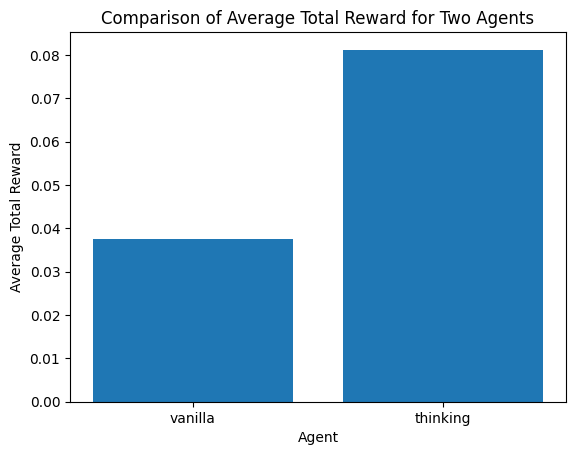

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

avg_rewards = {
    a: np.mean([ep["total_reward"] for ep in eps])
    for a, eps in baseline_episodes.items()
}

# make a bar chart
agents = list(avg_rewards.keys())
rewards = list(avg_rewards.values())

plt.bar(agents, rewards)
plt.xlabel("Agent")
plt.ylabel("Average Total Reward")
plt.title("Comparison of Average Total Reward for Two Agents")
plt.show()

# II. Supervised Fine-tuning (SFT) with Low-rank Adaptation (LORA)

In many problems, it is possible to collect demonstration data and learned an optimal strategy with supervision. For example, this could mean a human playing the game. In our case, text world comes with an engine to generate "gold paths" which help solve the task.

**Learning Plan**

* 📚 We will setup the LLM for efficient training using parameter efficient fine-tuning with LORA [(Hu et al., 2021)](https://arxiv.org/abs/2106.09685).
* 🥇 We will use the gold path engine to create a demonstration dataset
* 🏋️‍♀️ We will use the demonstration dataset for SFT
* 📈 We will evaluate the improved LLM

### 2.1 A primer on SFT and LORA

🕸️ LLMs are just neural networks. In particular, LLMs use the `transformer` architecture introduced in the paper *Attention Is All You Need*  [(Vaswani et al., 2017)](https://arxiv.org/abs/1706.03762). There is a good reason why this paper has over 100k citations ❗️


<figure>
<img src="https://drive.google.com/uc?export=view&id=1isVB0kvxCiE4Mz6eWaDaUu1QDI5BvZNC" alt="drawing" width="600"/>
<figcaption>
<b>Fig.</b> Schemetic representation of the Transformer Architecture and next-token prediction task.<br><em>Original image and blogpost</em>: <a href='https://medium.com/@akash.kesrwani99/understanding-next-token-prediction-concept-to-code-1st-part-7054dabda347'>Understanding Next Token Prediction: Concept To Code: 1st part!</a>
</figcaption>
</figure>


* 🔧 **Fine-tuning** 🔧
  * Fine tuning means updating the weights (parameters) of the neural network using a smaller dataset (aka downstream task).
  * In the context of LLM agents, we may also call this step *grounding* to the task.
  * Finetuning is typically done for far fewer optimization steps than the original training, and usually with smaller learning rates.
  * Finetuning is almost always better than training a model from scratch on the new ata.

* 🎻 **Classic approach** 🎻
  * *Last-layer tuning*: Retraining only the last layer of neural network.
  * *Full finetuning*: Update all weights of the network.
In regular neural network, it is common to update *all* the weights of neural network during finetuning.

#### 🦜 **LORA** 🦜
  * LORA takes the best of both finetuning regimes. Few parameters to train, but performs much better than last-layer tuning because it improves the entire neural network.
  * LORA or its many variations have become the standard to finetune LLMs [(Mao et al., 2024)](https://arxiv.org/abs/2407.11046)
  * The main idea is train an *low-rank adapter* as follows, which, for every parameter of the neural network, adds a new weight with fewer free parameters using the magic of low-rank matrix product factorization. The idea is illustrated below.
* 😱 **Worry not!** 😱
  * LORA is easily used without understanding its detailed inner workings.


<figure>
<img src="https://drive.google.com/uc?export=view&id=1HHeFZPdrVQWvA1EbWTHtyAuw_YNJjc-B" alt="drawing" width="800"/>
<figcaption>
<b>Fig.</b> Illustration of LORA.<br><em>Original image</em>: <a href='https://huggingface.co/docs/peft/main/en/developer_guides/lora'>HuggingFace PEFT docs</a>
</figcaption>
</figure>

#### 🏋🏽‍♂️ SFT is still next-token prediction** 🏋🏽‍♂️


In LLMs, the next-token prediction is trained using the **Cross-entropy Loss**, which measures how well the model's predicted probability distribution aligns with the true next token. SFT still uses this loss.

$$
\mathcal{L} = - \frac{1}{N} \sum_{i=1}^{N} \log \hat{P}_{\theta}(x_i | x_{<i})
$$

where:
- $N$ is the number of tokens in the sequence,
- $\hat{P}_{\theta}(x_i | x_{<i})$ represents the **predicted probability** of the correct token $x_i$ given the previous tokens,
- $x_{<i}$ represents the **context** (all previous tokens up to position $i$).

Since modern LLMs output **logits** (unnormalized scores for each token in the vocabulary), the probability $\hat{P}_{\theta}(x_i | x_{<i})$ is obtained by applying a **softmax**:

$$
\hat{P}_{\theta}(x_i | x_{<i}) = \frac{\exp(\text{logit}_{i, x_i})}{\sum_{j=1}^{V} \exp(\text{logit}_{i, j})}
$$

where:
- $\text{logit}_{i, x_i}$ is the model's predicted score for the correct next token $x_i$ at position $i$,
- $V$ is the vocabulary size,
- The denominator sums over all token scores to normalize them.


🐍 Cross-entropy in Pytorch 🐍

The cross-entropy is computed using `torch.nn.functional.cross_entropy`, which **directly takes raw logits** (not softmaxed) and target indices:

```python
# Example logits from a model (batch_size=1, seq_len=5, vocab_size=10)
logits = torch.tensor([
    [  # Sequence of 5 tokens (seq_len=5), each with vocab_size=10 logits
        [2.0, 1.0, 0.1, 3.2, 0.5, 2.3, 1.1, 0.2, 0.4, 1.7],  # Token 1
        [1.1, 2.5, 0.3, 2.8, 1.6, 1.7, 0.5, 0.7, 0.9, 1.3],  # Token 2
        [0.9, 1.4, 3.1, 1.5, 1.3, 0.8, 2.1, 1.9, 2.4, 0.7],  # Token 3
        [2.2, 0.5, 1.7, 1.8, 0.3, 2.6, 1.2, 1.5, 1.9, 0.6],  # Token 4
        [1.7, 2.2, 1.0, 1.4, 2.3, 0.9, 1.5, 1.6, 2.1, 1.8]   # Token 5
    ]
])  # Shape: (batch_size=1, seq_len=5, vocab_size=10)

# Target tokens (ground truth indices), same shape as seq_len
targets = torch.tensor([[3, 1, 2, 5, 4]])  # Shape: (batch_size=1, seq_len)

# Compute cross-entropy loss directly
loss = torch.nn.functional.cross_entropy(logits, targets)
```

### 2.2 Gather the Demonstration dataset

The strategy will be to mimic our previous episode_rollout busing the `env.getGoldActionSequence()` feature and execute that path.

In [ ]:
def expert_episode_rollout(
    gameFold: str = Literal["train", "valditation", "test"],
    env_factory_options: dict = {},
):
    # Initialize env
    env = env_factory(**env_factory_options)
    obs, infos = env.reset(gameFold=gameFold, generateGoldPath=True)
    gold_actions = env.getGoldActionSequence()

    # Initialize Memory
    memory = []
    memory.append("## Welcome to TextWorld")
    memory.append(f"`[Task]`: {env.getTaskDescription()}")
    memory.append(f"`[Starting Obs]`: {obs}")

    # Make initial plan
    # Print progress
    pbar = tqdm(desc="Episode Progress")

    # Collected prompt/action/reward triples for training
    collected_data = []

    # Start loop
    done = False
    total_reward = 0.0

    step = 0
    while not done:
        # Update task prompt
        memory.append(f"***`Action step {step}`**")
        memory.append(f"`[Time]` {datetime.now().strftime('%H:%M:%S')}")
        memory.append(f"`[Valid Actions]`: {infos['validActions']}")
        task_prompt = build_task_prompt(memory)

        # Execute gold path action
        action = gold_actions[step]

        # Advance the Environment
        obs, reward, done, infos = env.step(action)

        # Update memory
        memory.append(f"`[Action]`: {action}")
        memory.append(f"`[Reward]`: {reward:0.2f}")
        memory.append(f"`[Obs]`: {obs}")

        collected_data.append((task_prompt, "", action, reward))  # empty for the thoughts

        total_reward += reward
        step += 1
        pbar.update(1)

    return memory, collected_data, total_reward

In [ ]:
expert_episodes = {'expert': []}

num_episodes_per_agent = 20

for ep in range(num_episodes_per_agent):
    memory, data, total_reward = expert_episode_rollout(gameFold="train")
    expert_episodes['expert'].append({"ep": ep, "total_reward": total_reward, "memory": memory, "data": data})

mean_reward_expert = np.mean([ep["total_reward"] for ep in expert_episodes["expert"]])
print(f"Mean reward for expert: {mean_reward_expert}")

# Visualize expert episode
printmd('\n\n'.join(expert_episodes['expert'][0]['memory']))

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Mean reward for expert: 0.7125


## Welcome to TextWorld

`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.

`[Starting Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. In one part of the room you see a toilet paper. There is also a comb. 
To the South you see a closed wood door. To the East you see a closed wood door. 

***`Action step 0`**

`[Time]` 09:27:21

`[Valid Actions]`: ['move south', 'open door to east', 'move east', 'take comb', 'inventory', 'close door to south', 'close door to east', 'take toilet paper', 'open door to south', 'open wastepaper basket', 'look around']

`[Action]`: look around

`[Reward]`: 0.00

`[Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. In one part of the room you see a toilet paper. There is also a comb. 
To the South you see a closed wood door. To the East you see a closed wood door. 

***`Action step 1`**

`[Time]` 09:27:21

`[Valid Actions]`: ['inventory', 'move east', 'close door to south', 'look around', 'open door to east', 'open wastepaper basket', 'take toilet paper', 'open door to south', 'take comb', 'close door to east', 'move south']

`[Action]`: take toilet paper

`[Reward]`: 0.12

`[Obs]`: You take the toilet paper.

***`Action step 2`**

`[Time]` 09:27:21

`[Valid Actions]`: ['move east', 'open door to east', 'put toilet paper in sofa', 'put toilet paper in book case', 'take comb', 'put toilet paper in end table', 'close door to east', 'open wastepaper basket', 'look around', 'move south', 'inventory', 'open door to south', 'put toilet paper in arm chair', 'put toilet paper in TV stand', 'put toilet paper in coffee table', 'close door to south', 'put toilet paper in side table']

`[Action]`: take comb

`[Reward]`: 0.12

`[Obs]`: You take the comb.

***`Action step 3`**

`[Time]` 09:27:21

`[Valid Actions]`: ['close door to south', 'put comb in coffee table', 'put toilet paper in end table', 'put comb in arm chair', 'put toilet paper in book case', 'look around', 'open door to east', 'put comb in end table', 'put toilet paper in arm chair', 'move south', 'open wastepaper basket', 'put comb in book case', 'put comb in TV stand', 'inventory', 'put comb in side table', 'put toilet paper in coffee table', 'open door to south', 'close door to east', 'put toilet paper in side table', 'put comb in sofa', 'put toilet paper in TV stand', 'move east', 'put toilet paper in sofa']

`[Action]`: open door to south

`[Reward]`: 0.00

`[Obs]`: You open the wood door, revealing the bedroom. 

***`Action step 4`**

`[Time]` 09:27:21

`[Valid Actions]`: ['put comb in book case', 'move east', 'put toilet paper in coffee table', 'open door to south', 'put comb in end table', 'put comb in sofa', 'put toilet paper in book case', 'put toilet paper in TV stand', 'put comb in side table', 'move south', 'close door to south', 'put comb in TV stand', 'put comb in coffee table', 'put toilet paper in side table', 'put toilet paper in sofa', 'inventory', 'put comb in arm chair', 'open door to east', 'close door to east', 'open wastepaper basket', 'put toilet paper in end table', 'put toilet paper in arm chair', 'look around']

`[Action]`: open door to east

`[Reward]`: 0.00

`[Obs]`: You open the wood door, revealing the bathroom. 

***`Action step 5`**

`[Time]` 09:27:21

`[Valid Actions]`: ['inventory', 'put comb in end table', 'put toilet paper in TV stand', 'put toilet paper in side table', 'close door to south', 'put comb in TV stand', 'put toilet paper in end table', 'open wastepaper basket', 'move south', 'put toilet paper in coffee table', 'put comb in arm chair', 'put comb in book case', 'close door to east', 'put toilet paper in arm chair', 'open door to east', 'open door to south', 'put toilet paper in sofa', 'put comb in sofa', 'move east', 'put comb in coffee table', 'put toilet paper in book case', 'put comb in side table', 'look around']

`[Action]`: move south

`[Reward]`: 0.00

`[Obs]`: You are in the bedroom. In one part of the room you see a dressing table, that has nothing on it. There is also a desk chair, that has nothing on it. You also see a desk, that has nothing on it. In another part of the room you see a chest of drawers that is closed. In one part of the room you see a wardrobe that is closed. There is also a night stand, that has nothing on it. You also see a bed, that has nothing on it. In another part of the room you see a handsoap. 
Through an open wood door, to the North you see the living room. 

***`Action step 6`**

`[Time]` 09:27:21

`[Valid Actions]`: ['close door to north', 'put toilet paper in desk chair', 'put toilet paper in desk', 'open door to north', 'put toilet paper in dressing table', 'inventory', 'put comb in bed', 'open wardrobe', 'move north', 'put toilet paper in night stand', 'put comb in night stand', 'look around', 'put toilet paper in bed', 'put comb in dressing table', 'take handsoap', 'put comb in desk', 'put comb in desk chair', 'open chest of drawers']

`[Action]`: take handsoap

`[Reward]`: 0.12

`[Obs]`: You take the handsoap.

***`Action step 7`**

`[Time]` 09:27:21

`[Valid Actions]`: ['put toilet paper in night stand', 'put toilet paper in dressing table', 'put handsoap in dressing table', 'move north', 'put toilet paper in desk chair', 'put handsoap in bed', 'put comb in desk chair', 'put toilet paper in desk', 'put handsoap in night stand', 'put comb in dressing table', 'put handsoap in desk chair', 'open wardrobe', 'open door to north', 'put comb in bed', 'put comb in night stand', 'close door to north', 'put handsoap in desk', 'inventory', 'open chest of drawers', 'put comb in desk', 'look around', 'put toilet paper in bed']

`[Action]`: move north

`[Reward]`: 0.00

`[Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. 
Through an open wood door, to the South you see the bedroom. Through an open wood door, to the East you see the bathroom. 

***`Action step 8`**

`[Time]` 09:27:21

`[Valid Actions]`: ['put handsoap in side table', 'put toilet paper in end table', 'put handsoap in end table', 'put handsoap in sofa', 'put toilet paper in TV stand', 'put toilet paper in book case', 'open door to south', 'put comb in side table', 'look around', 'put comb in coffee table', 'put comb in book case', 'open wastepaper basket', 'put comb in end table', 'put toilet paper in sofa', 'put handsoap in TV stand', 'put comb in arm chair', 'put handsoap in arm chair', 'put comb in TV stand', 'put handsoap in book case', 'open door to east', 'close door to south', 'put comb in sofa', 'inventory', 'put toilet paper in side table', 'move east', 'put handsoap in coffee table', 'move south', 'put toilet paper in arm chair', 'put toilet paper in coffee table', 'close door to east']

`[Action]`: move east

`[Reward]`: 0.00

`[Obs]`: You are in the bathroom. In one part of the room you see a dressing table, that has nothing on it. There is also a sink, that has nothing on it. You also see a wall hook, that has nothing on it. In another part of the room you see a bath mat. In one part of the room you see a toilet roll holder, that has nothing on it. There is also a towel rack, that has nothing on it. You also see a bath tub, that has nothing on it. In another part of the room you see a shower, that has nothing on it. In one part of the room you see a trash can that is closed. There is also a bathroom cabinet that is closed. You also see a toilet. In another part of the room you see a brown belt. 
Through an open wood door, to the West you see the living room. 

***`Action step 9`**

`[Time]` 09:27:21

`[Valid Actions]`: ['put toilet paper in towel rack', 'open door to west', 'put toilet paper in wall hook', 'put comb in shower', 'open bathroom cabinet', 'put toilet paper in dressing table', 'put comb in wall hook', 'put toilet paper in sink', 'put toilet paper in shower', 'put comb in toilet roll holder', 'put handsoap in sink', 'put comb in bath tub', 'take brown belt', 'look around', 'put handsoap in wall hook', 'put handsoap in shower', 'put toilet paper in toilet roll holder', 'put handsoap in towel rack', 'put toilet paper in bath tub', 'put handsoap in toilet roll holder', 'inventory', 'put comb in dressing table', 'open trash can', 'put comb in towel rack', 'put comb in sink', 'put handsoap in bath tub', 'put handsoap in dressing table', 'move west', 'close door to west']

`[Action]`: take brown belt

`[Reward]`: 0.12

`[Obs]`: You take the brown belt.

***`Action step 10`**

`[Time]` 09:27:21

`[Valid Actions]`: ['put brown belt in towel rack', 'put toilet paper in sink', 'put handsoap in dressing table', 'put handsoap in wall hook', 'put handsoap in towel rack', 'put brown belt in dressing table', 'put brown belt in wall hook', 'put toilet paper in bath tub', 'put comb in toilet roll holder', 'put handsoap in toilet roll holder', 'open bathroom cabinet', 'put toilet paper in shower', 'look around', 'inventory', 'close door to west', 'open door to west', 'put toilet paper in dressing table', 'put handsoap in bath tub', 'put comb in bath tub', 'put handsoap in sink', 'put comb in dressing table', 'put brown belt in bath tub', 'move west', 'open trash can', 'put comb in wall hook', 'put handsoap in shower', 'put brown belt in shower', 'put toilet paper in toilet roll holder', 'put comb in shower', 'put toilet paper in wall hook', 'put comb in sink', 'put toilet paper in towel rack', 'put brown belt in toilet roll holder', 'put comb in towel rack', 'put brown belt in sink']

`[Action]`: put toilet paper in toilet roll holder

`[Reward]`: 0.12

`[Obs]`: You put the toilet paper in the toilet roll holder.

***`Action step 11`**

`[Time]` 09:27:21

`[Valid Actions]`: ['open bathroom cabinet', 'put handsoap in toilet roll holder', 'inventory', 'put handsoap in towel rack', 'put brown belt in dressing table', 'put brown belt in toilet roll holder', 'put comb in towel rack', 'put comb in wall hook', 'put handsoap in dressing table', 'put brown belt in bath tub', 'put handsoap in bath tub', 'put brown belt in wall hook', 'put comb in toilet roll holder', 'put handsoap in sink', 'open door to west', 'put comb in shower', 'move west', 'put brown belt in towel rack', 'put brown belt in shower', 'open trash can', 'put brown belt in sink', 'take toilet paper', 'put comb in dressing table', 'put comb in sink', 'put comb in bath tub', 'put handsoap in wall hook', 'put handsoap in shower', 'close door to west', 'look around']

`[Action]`: open bathroom cabinet

`[Reward]`: 0.00

`[Obs]`: You open the bathroom cabinet. It's empty inside.

***`Action step 12`**

`[Time]` 09:27:21

`[Valid Actions]`: ['take toilet paper', 'look around', 'open door to west', 'put comb in sink', 'put brown belt in toilet roll holder', 'close bathroom cabinet', 'put comb in bathroom cabinet', 'put brown belt in shower', 'put comb in shower', 'put handsoap in shower', 'put comb in bath tub', 'put brown belt in sink', 'put handsoap in towel rack', 'put brown belt in wall hook', 'put handsoap in toilet roll holder', 'put brown belt in bathroom cabinet', 'open trash can', 'move west', 'put comb in toilet roll holder', 'close door to west', 'put comb in wall hook', 'put brown belt in bath tub', 'put handsoap in sink', 'put comb in towel rack', 'put handsoap in bathroom cabinet', 'put handsoap in bath tub', 'put handsoap in wall hook', 'inventory', 'put handsoap in dressing table', 'put brown belt in dressing table', 'put comb in dressing table', 'put brown belt in towel rack']

`[Action]`: put comb in bathroom cabinet

`[Reward]`: 0.12

`[Obs]`: You put the comb in the bathroom cabinet.

With this explanation in mind, let us start with collecting the expert data into a more usable format.

In [ ]:
# 1. Combine all the data
data_list = []
for ep in expert_episodes["expert"]:
    for prompt, _, action, _ in ep["data"]:
        data_list.append({"prompt": prompt, "action": action})
data_list[0]

{'prompt': "## Welcome to TextWorld\n\n`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.\n\n`[Starting Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. In one part of the room you see a toilet paper. There is also a comb. \nTo the South you see a closed wood door. To the East you see a closed wood door. \n\n***`Action step 0`**\n\n`[Time]` 09:27:21\n\n`[Valid Actions]`: ['move south', 'open door to east', 'move east', 'take comb', 'inventory', 'close door to south', 'close

### 2.3 Training / Fine-tuning


We now use the `peft` library to setup LORA. Incredibly, only 0.03% of the weights will need to be updated.

In [ ]:
from peft import LoraConfig, TaskType

# LORA config
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=4,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none"
)

# Wrap the original model. The wrapped model has fewer trainable paramters
model_lora = peft.get_peft_model(model, peft_config)
model_lora.print_trainable_parameters()

display(model_lora)

trainable params: 425,984 || all params: 1,236,240,384 || trainable%: 0.0345


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 2048)
        (layers): ModuleList(
          (0-15): 16 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=4, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=4, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): Linear(in_fea

Next, let's break down an example of how we compute the loss with one of the entries of our collected data.

ℹ️ Pay attention to the tokenizations scheme. It's easy to miss! We need to make sure the prompt is transformed to the chat template used by the LLM ℹ️

In [ ]:
prompt, action = data_list[0]["prompt"], data_list[0]["action"]

# we need to obtain the full prompt first
action_prompt = prompt + (
    "\n\nNow, choose exactly one valid action from the list and no additional information.\n"
      f"The valid actions are: {','.join(valid_actions)}\n"
)
messages = {"role": "user", "content": action_prompt}
full_prompt = tokenizer.apply_chat_template([messages], tokenize=False, add_generation_prompt=True)

action_with_eot = action + "<|eot_id|><|start_header_id|>assistant<|end_header_id|>" # !!!!
tokenized_prompt = tokenizer(full_prompt, return_tensors="pt").input_ids.to("cuda")[0]
tokenized_action = tokenizer(action_with_eot, return_tensors="pt").input_ids.to("cuda")[0]

print(f"> Prompt: {full_prompt}\n")
print(f"> Tokenized Prompt: {tokenized_prompt}\n")
print(f"> Action: {action_with_eot}\n")
print(f"> Tokenized Action: {tokenized_action}\n")

# concatenate prompt/action that will be the input to the language model for next
# token prediction. We don't need to include the last token of the action, since
# it is only used as a label for the next token prediction later.
device = "cuda" if torch.cuda.is_available() else "cpu"
input_ids = torch.cat([tokenized_prompt, tokenized_action[:-1]]).to(device)

# eval LLM - we need the extra dimension since the model expects a batch
# this is achieved by unsqueeze(0)
outputs = model_lora(input_ids.unsqueeze(0))
print(f"> Model outputs: {outputs}")

# Now we will compute the next token prediction loss, but only on the last tokens
# for the action.
# The loss is the cross entropy with the logits and the true next tokens (i.e., the action tokens)
num_action_tokens = len(tokenized_action)
next_token_logits = outputs.logits[0, -num_action_tokens:]
loss = torch.nn.functional.cross_entropy(next_token_logits, tokenized_action)
print(f"> Cross entropy loss Loss: {loss:.2f}")

# clean up
del outputs, loss, next_token_logits
torch.cuda.empty_cache()

> Prompt: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 07 Mar 2025

<|eot_id|><|start_header_id|>user<|end_header_id|>

## Welcome to TextWorld

`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.

`[Starting Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. In one part of the room you see a toilet paper. There is also a comb. 
To the South you see a closed wood door. To the East you see a closed wood door. 

*


🏋️‍♀️ **We are ready to train**🏋️‍♀️ All that is left is to compute the loss and call the optimizer ineach step.

𝝯 **Gradient accumulation** 𝝯 We did not implement batches, which is typically used to improve training. But we can use a very simple trick called gradient accumulation. This trick is handy particularly with larger models when batched training does not fit in memory.


In [ ]:
import accelerate
import peft


def train(model, tokenizer, data_list, epochs=20):
    """
    Train function that ensures memory is freed after training.

    Args:
        model (torch.nn.Module): The model to be trained.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for processing text inputs.
        data_list (list): The dataset containing prompts and actions.
        epochs (int, optional): Number of epochs. Defaults to 20.
    """
    # Set model in train mode (e.g., dropout on)
    model.train()

    # standard choice of optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=2e-5,
        betas=(0.9, 0.95),
        eps=1e-8,
        weight_decay=0.01,
    )

    # accelerator for the gradient accumulation and device management
    accelerator = accelerate.Accelerator(gradient_accumulation_steps=4)
    model, optimizer = accelerator.prepare(model, optimizer)
    device = accelerator.device

    all_losses = []

    # training loop
    for epoch in range(epochs):
        epoch_losses = []

        # random order of data
        indices = np.random.permutation(len(data_list))

        for i in tqdm(range(len(data_list))):
            data = data_list[indices[i]]
            action = data["action"]
            task_prompt = data["prompt"]

            # Make full prompt
            action_prompt = task_prompt + (
                "\n\nNow, choose exactly one valid action from the list and no additional information.\n"
                f"The valid actions are: {','.join(valid_actions)}\n"
            )
            messages = {"role": "user", "content": action_prompt}
            full_prompt = tokenizer.apply_chat_template([messages], tokenize=False, add_generation_prompt=True)

            # Tokenize inputs and move to device
            prompt_tokens = tokenizer(full_prompt, return_tensors="pt").input_ids.to(device)[0]
            action_with_eot = action + "<|eot_id|><|start_header_id|>assistant<|end_header_id|>" # !!!! Easy to miss
            action_tokens = tokenizer(action_with_eot, return_tensors="pt").input_ids.to(device)[0]
            input_ids = torch.cat([prompt_tokens, action_tokens[:-1]])

            # Compute loss with gradient accumulation
            with accelerator.accumulate(model):
                outputs = model(input_ids.unsqueeze(0))
                num_action_tokens = len(action_tokens)
                next_token_logits = outputs.logits[0, -num_action_tokens:]
                loss = torch.nn.functional.cross_entropy(next_token_logits, action_tokens)

            optimizer.zero_grad()
            accelerator.backward(loss)
            optimizer.step()
            epoch_losses.append(loss.item())

            # free CUDA memory at every step
            torch.cuda.empty_cache()

        print(f"Epoch {epoch+1} | Loss: {np.mean(epoch_losses):.2f}")
        all_losses.extend(epoch_losses)

    # Set model back to eval
    model.eval()

    return all_losses

# Start training
# all_losses = train(model_lora, tokenizer, data_list, epochs=5)
# model_lora.save_pretrained(f"{target_dir}/sft_lora")
# with open(f"{target_dir}/sft_losses.json", "w") as f:
#     json.dump(all_losses, f)

## Load from pretrained weights on github
## Comment following lines if training
!rm -rf hdsi-winter-workshop && git clone https://github.com/mauriciogtec/hdsi-winter-workshop
all_losses = json.load(open(f"hdsi-winter-workshop/sft_losses.json", "r"))

# Combine LORA adapter with the original LLM weights
model_lora = peft.PeftModel.from_pretrained(model, f"hdsi-winter-workshop/sft_lora/")


Cloning into 'hdsi-winter-workshop'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 62 (delta 29), reused 45 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (62/62), 2.17 MiB | 27.09 MiB/s, done.
Resolving deltas: 100% (29/29), done.


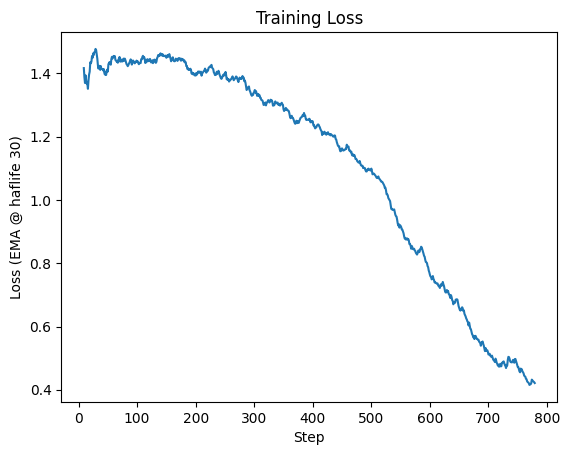

In [ ]:
# @title SFT loss
import pandas as pd
pd.Series(all_losses).ewm(halflife=30, min_periods=10).mean().plot()
plt.xlabel("Step")
plt.ylabel("Loss (EMA @ haflife 30)")
plt.title("Training Loss")
plt.show()


### 2.4 Evaluate SFT policy

In [ ]:
## Run eval loop with fine-tuned model
sft_episodes = {"sft": []}
num_episodes_per_agent = 30

for ep in range(num_episodes_per_agent):
    printmd(f"#### Episode {ep}")
    memory, data, total_reward = episode_rollout(model_lora, gameFold="test", thinking=False, seed=ep * 123)
    sft_episodes['sft'].append({"ep": ep, "total_reward": total_reward, "memory": memory, "data": data})

## save results
with open(f"{target_dir}/episodes_sft_agent.json", "w") as f:
    json.dump(sft_episodes, f)

## print an episode
printmd('\n\n'.join(sft_episodes['sft'][0]['memory']))

#### Episode 0

Episode Progress: 0it [00:00, ?it/s]

#### Episode 1

Episode Progress: 0it [00:00, ?it/s]

#### Episode 2

Episode Progress: 0it [00:00, ?it/s]

#### Episode 3

Episode Progress: 0it [00:00, ?it/s]

#### Episode 4

Episode Progress: 0it [00:00, ?it/s]

#### Episode 5

Episode Progress: 0it [00:00, ?it/s]

#### Episode 6

Episode Progress: 0it [00:00, ?it/s]

#### Episode 7

Episode Progress: 0it [00:00, ?it/s]

#### Episode 8

Episode Progress: 0it [00:00, ?it/s]

#### Episode 9

Episode Progress: 0it [00:00, ?it/s]

#### Episode 10

Episode Progress: 0it [00:00, ?it/s]

#### Episode 11

Episode Progress: 0it [00:00, ?it/s]

#### Episode 12

Episode Progress: 0it [00:00, ?it/s]

#### Episode 13

Episode Progress: 0it [00:00, ?it/s]

#### Episode 14

Episode Progress: 0it [00:00, ?it/s]

#### Episode 15

Episode Progress: 0it [00:00, ?it/s]

#### Episode 16

Episode Progress: 0it [00:00, ?it/s]

#### Episode 17

Episode Progress: 0it [00:00, ?it/s]

#### Episode 18

Episode Progress: 0it [00:00, ?it/s]

#### Episode 19

Episode Progress: 0it [00:00, ?it/s]

#### Episode 20

Episode Progress: 0it [00:00, ?it/s]

#### Episode 21

Episode Progress: 0it [00:00, ?it/s]

#### Episode 22

Episode Progress: 0it [00:00, ?it/s]

#### Episode 23

Episode Progress: 0it [00:00, ?it/s]

#### Episode 24

Episode Progress: 0it [00:00, ?it/s]

#### Episode 25

Episode Progress: 0it [00:00, ?it/s]

#### Episode 26

Episode Progress: 0it [00:00, ?it/s]

#### Episode 27

Episode Progress: 0it [00:00, ?it/s]

#### Episode 28

Episode Progress: 0it [00:00, ?it/s]

#### Episode 29

Episode Progress: 0it [00:00, ?it/s]

`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.

`[Starting Obs]`: You are in the kitchen. In one part of the room you see a stove. There is also an oven. You also see a fridge that is closed. In another part of the room you see a counter, that has nothing on it. In one part of the room you see a kitchen cupboard that is closed. There is also a cutlery drawer that is closed. You also see a trash can that is closed. In another part of the room you see a dishwasher that is closed. In one part of the room you see a dining chair, that has nothing on it. There is also a newspaper. You also see a dirty mesh skimmer. 
To the West you see the living room. 

###  `Action step 1`

`[Time]` 09:27:33

`[Valid Actions]`: ['open kitchen cupboard', 'take newspaper', 'take dirty mesh skimmer', 'open trash can', 'open fridge', 'open cutlery drawer', 'move west', 'inventory', 'open dishwasher', 'look around']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. In one part of the room you see a can opener. There is also a milk. 
To the East you see the kitchen. To the West you see a closed wood door. 

###  `Action step 2`

`[Time]` 09:27:33

`[Valid Actions]`: ['look around', 'inventory', 'open door to west', 'move west', 'open wastepaper basket', 'close door to west', 'take can opener', 'take milk', 'move east']

`[Action]`: take can opener

`[Reward]`: 0.12

`[Obs]`: You take the can opener.

###  `Action step 3`

`[Time]` 09:27:33

`[Valid Actions]`: ['put can opener in sofa', 'put can opener in arm chair', 'put can opener in book case', 'put can opener in TV stand', 'open wastepaper basket', 'move west', 'move east', 'inventory', 'close door to west', 'open door to west', 'put can opener in coffee table', 'take milk', 'put can opener in side table', 'put can opener in end table', 'look around']

`[Action]`: move east

`[Reward]`: 0.00

`[Obs]`: You are in the kitchen. In one part of the room you see a stove. There is also an oven. You also see a fridge that is closed. In another part of the room you see a counter, that has nothing on it. In one part of the room you see a kitchen cupboard that is closed. There is also a cutlery drawer that is closed. You also see a trash can that is closed. In another part of the room you see a dishwasher that is closed. In one part of the room you see a dining chair, that has nothing on it. There is also a newspaper. You also see a dirty mesh skimmer. 
To the West you see the living room. 

###  `Action step 4`

`[Time]` 09:27:33

`[Valid Actions]`: ['look around', 'put can opener in counter', 'take dirty mesh skimmer', 'open kitchen cupboard', 'open trash can', 'take newspaper', 'open fridge', 'move west', 'put can opener in dining chair', 'open dishwasher', 'inventory', 'open cutlery drawer']

`[Action]`: take dirty mesh skimmer

`[Reward]`: 0.12

`[Obs]`: You take the dirty mesh skimmer.

###  `Action step 5`

`[Time]` 09:27:33

`[Valid Actions]`: ['put can opener in dining chair', 'put dirty mesh skimmer in dining chair', 'put dirty mesh skimmer in counter', 'take newspaper', 'open dishwasher', 'look around', 'open trash can', 'open kitchen cupboard', 'put can opener in counter', 'inventory', 'open cutlery drawer', 'move west', 'open fridge']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. In one part of the room you see a milk. 
To the East you see the kitchen. To the West you see a closed wood door. 

###  `Action step 6`

`[Time]` 09:27:34

`[Valid Actions]`: ['put can opener in TV stand', 'open wastepaper basket', 'open door to west', 'put can opener in side table', 'put dirty mesh skimmer in sofa', 'put dirty mesh skimmer in end table', 'take milk', 'put dirty mesh skimmer in arm chair', 'put dirty mesh skimmer in coffee table', 'put can opener in coffee table', 'move east', 'put dirty mesh skimmer in TV stand', 'inventory', 'put can opener in sofa', 'put can opener in end table', 'put dirty mesh skimmer in book case', 'look around', 'move west', 'put dirty mesh skimmer in side table', 'put can opener in book case', 'put can opener in arm chair', 'close door to west']

`[Action]`: move east

`[Reward]`: 0.00

`[Obs]`: You are in the kitchen. In one part of the room you see a stove. There is also an oven. You also see a fridge that is closed. In another part of the room you see a counter, that has nothing on it. In one part of the room you see a kitchen cupboard that is closed. There is also a cutlery drawer that is closed. You also see a trash can that is closed. In another part of the room you see a dishwasher that is closed. In one part of the room you see a dining chair, that has nothing on it. There is also a newspaper. 
To the West you see the living room. 

###  `Action step 7`

`[Time]` 09:27:34

`[Valid Actions]`: ['take newspaper', 'put can opener in counter', 'put can opener in dining chair', 'move west', 'open kitchen cupboard', 'open fridge', 'open trash can', 'open dishwasher', 'put dirty mesh skimmer in dining chair', 'put dirty mesh skimmer in counter', 'look around', 'open cutlery drawer', 'inventory']

`[Action]`: put dirty mesh skimmer in dining chair

`[Reward]`: -0.12

`[Obs]`: You put the dirty mesh skimmer in the dining chair.

###  `Action step 8`

`[Time]` 09:27:34

`[Valid Actions]`: ['move west', 'take dirty mesh skimmer', 'open cutlery drawer', 'open kitchen cupboard', 'take newspaper', 'put can opener in counter', 'open trash can', 'look around', 'open fridge', 'inventory', 'put can opener in dining chair', 'open dishwasher']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. In one part of the room you see a milk. 
To the East you see the kitchen. To the West you see a closed wood door. 

###  `Action step 9`

`[Time]` 09:27:35

`[Valid Actions]`: ['open door to west', 'put can opener in sofa', 'put can opener in coffee table', 'put can opener in arm chair', 'close door to west', 'put can opener in book case', 'take milk', 'open wastepaper basket', 'put can opener in side table', 'move west', 'move east', 'put can opener in end table', 'inventory', 'put can opener in TV stand', 'look around']

`[Action]`: open door to west

`[Reward]`: 0.00

`[Obs]`: You open the wood door, revealing the bedroom. 

###  `Action step 10`

`[Time]` 09:27:35

`[Valid Actions]`: ['put can opener in sofa', 'open door to west', 'take milk', 'put can opener in book case', 'open wastepaper basket', 'move east', 'look around', 'put can opener in coffee table', 'put can opener in arm chair', 'put can opener in side table', 'move west', 'inventory', 'put can opener in TV stand', 'close door to west', 'put can opener in end table']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You are in the bedroom. In one part of the room you see a dressing table, that has nothing on it. There is also a desk chair, that has nothing on it. You also see a desk, that has nothing on it. In another part of the room you see a chest of drawers that is closed. In one part of the room you see a wardrobe that is closed. There is also a night stand, that has nothing on it. You also see a bed, that has nothing on it. 
Through an open wood door, to the East you see the living room. 

###  `Action step 11`

`[Time]` 09:27:35

`[Valid Actions]`: ['put can opener in bed', 'put can opener in night stand', 'inventory', 'put can opener in desk', 'look around', 'put can opener in dressing table', 'open chest of drawers', 'put can opener in desk chair', 'open door to east', 'move east', 'open wardrobe', 'close door to east']

`[Action]`: move east

`[Reward]`: 0.00

`[Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. In one part of the room you see a milk. 
To the East you see the kitchen. Through an open wood door, to the West you see the bedroom. 

###  `Action step 12`

`[Time]` 09:27:36

`[Valid Actions]`: ['close door to west', 'move west', 'open wastepaper basket', 'put can opener in coffee table', 'put can opener in arm chair', 'take milk', 'put can opener in end table', 'look around', 'put can opener in sofa', 'put can opener in side table', 'put can opener in TV stand', 'inventory', 'open door to west', 'put can opener in book case', 'move east']

`[Action]`: look around

`[Reward]`: 0.00

`[Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. In one part of the room you see a milk. 
To the East you see the kitchen. Through an open wood door, to the West you see the bedroom. 

###  `Action step 13`

`[Time]` 09:27:36

`[Valid Actions]`: ['put can opener in TV stand', 'open door to west', 'take milk', 'move west', 'look around', 'close door to west', 'inventory', 'put can opener in arm chair', 'put can opener in side table', 'put can opener in coffee table', 'put can opener in book case', 'move east', 'open wastepaper basket', 'put can opener in sofa', 'put can opener in end table']

`[Action]`: put can opener in arm chair

`[Reward]`: -0.12

`[Obs]`: You put the can opener in the arm chair.

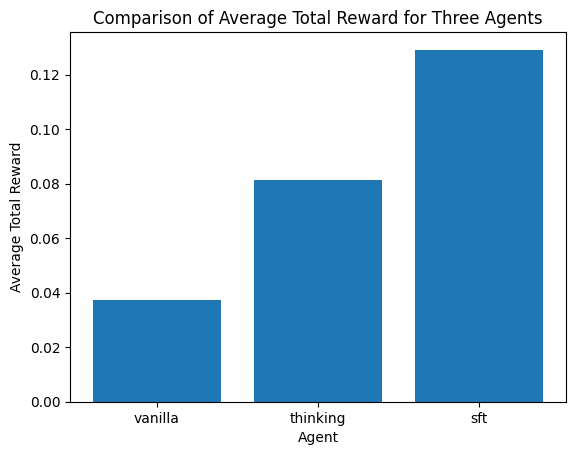

In [ ]:
# import numpy as np
import matplotlib.pyplot as plt

all_eps = baseline_episodes | sft_episodes

avg_rewards = {
    a: np.mean([ep["total_reward"] for ep in all_eps[a]])
    for a in ["vanilla", "thinking", "sft"]
}

# make a bar chart
agents = list(avg_rewards.keys())
rewards = list(avg_rewards.values())

plt.bar(agents, rewards)
plt.xlabel("Agent")
plt.ylabel("Average Total Reward")
plt.title("Comparison of Average Total Reward for Three Agents")
plt.show()

# III. Reinforcement Learning


* 🥅 **Limitations of SFT** 🥅 Supervised fine-tuning refines LLMs using static datasets, there are some problems:
    * ❌ The SDR objective may be misaligned with the true objective of optimizing reward over time. This small mismatch can reduce overall peformance.
    * 🤔 In fact, SFT has been studied under the name *Behavioral Cloning* in the RL literature, showing the distribution shift between the expert and the learning agent can create several problems [(Zare et al., 2023)](https://arxiv.org/abs/2309.02473)..


 * 🐕 **Reinforcement Learning** 🐕
  * 🦾 RL addresses the limitations in SFT by enabling models to learn optimal behaviors through trial and error within interactive settings using a reward signal as feedback. In our case, we will employ RL to train LLMs using the TextWorld reward.
  * 😓 RL is very hard to train! Here we will make several simplifications to het a small feel of the approach.


* 📚 **Learning Plan**📚
  1. Let's start with an overview of RL of MDPs.
  2. Let's explain the policy gradients approach. We will use a super simplified version of proximal policy optimization [(Schulman et al. 2017)](https://arxiv.org/abs/1707.06347).
  3. We will implement a training loop and use it to further refine our SFT agent.



<figure>
<img src="https://drive.google.com/uc?export=view&id=1v3eVKBfTXUymQOg1ID4ha-l9bMYCtha0" alt="drawing" width="800"/>
<figcaption>
<b>Fig.</b> Turing award winners.<br><em>Original article</em>: <a href='https://www.nytimes.com/welcome-subscriber/interest-selection?EXIT_URI=https%3A%2F%2Fwww.nytimes.com%2F2025%2F03%2F05%2Ftechnology%2Fturing-award-andrew-barto-richard-sutton.html'>Turing Award Goes to 2 Pioneers of Artificial Intelligence</a>
</figcaption>
</figure> -->



## 3.1 A Primer on RL



### 🎯 RL and MDPs

RL trains an agent through **interaction** 🕹️ with an environment, aiming to **maximize cumulative rewards** 💰. Unlike supervised learning (labels) or unsupervised learning (patterns), RL relies solely on **trial-and-error feedback**.

**Key components** of an RL setup:
- **Agent** 🤖 chooses actions.
- **Environment** 🌎 provides feedback (state & reward).
- **Reward** 🏅 signals how good the action was.

The RL problem is formalized using **Markov Decision Processes (MDPs)**:
- **State** $s_t$ 📍: Current situation.
- **Action** $a_t$ 🎮: Decision taken by the agent.
- **Reward** $r_t$ 🏅: Immediate feedback from the environment.

The goal 🏆:
$$
\text{Maximize expected return } J = \mathbb{E}\left[\sum_{t=0}^{H-1} r_t\right].
$$

### ∇∇ Policy Gradients

Policy gradients directly optimize the probability of choosing action $a$ in state $s$, aka, the policy $\pi_\theta(a|s)$, to maximize cumulative rewards. Instead of learning values, we adjust policy parameters $\theta$ via **gradient ascent** 📈.

The policy gradient theorem says:
$$
\nabla_{\theta} J(\theta) = \mathbb{E}\left[ \nabla_{\theta} \log \pi_{\theta}(a|s) \cdot G_t \right]
$$
where $G_t = \sum_{h=t}^{H-1} r_t$ is the **return**: the cumulative reward from the current time $t$ until the end of the episode.

In plain English 📚:
> "Increase the likelihood of actions that yield higher returns and decrease for lower returns."
<!--
**Proximal Policy Optimization (PPO)** 📌:
- PPO stabilizes training by limiting policy changes.
- Uses a clipped objective to prevent drastic policy updates:
$$
L^{\text{PPO}}(\theta) = \mathbb{E}\left[ \min(r_t(\theta)G_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)G_t) \right]
$$

where $r_t(\theta) = \frac{\pi_{\theta}(a|s)}{\pi_{\theta_{\text{old}}}(a|s)}$.

PPO's simple mantra 🧘:
> "Improve gently, avoid radical changes."

That's it! Now we're ready to fine-tune the LLM with RL using policy gradients! 🌟 -->


### 💰 How to Assign Token-level Rewards in RL for LLMs

To fine-tune an LLM using Reinforcement Learning, we must assign rewards at the token level. But how do we do this if our environment only provides a reward at the end of a full response?

Here's the trick ✨: we simply treat the final reward as the **return** (total reward) and assign it equally to all tokens generated in that sequence. In simple terms 🗣️:  
> *"If your final response is rewarded, every token that helped create that response shares the credit equally!"*

Now you're ready to apply RL to fine-tune your LLMs at the token level! 🚀

## 3.2 RL Training

The strategy involve two alternating steps:

1. Collect data from rollouts
2. Update the policy

We will first go through each step to illustrate the computation, and then provide the complete loop.

 ℹ️
 For pedagogical reasons, the version of policy gradients / RL we will implement is simplified. In particular, we will not GAE return estiation. We will not implement the PPO clipping loss. And we will also note use a KL reward with respect to a reference policy, which is commonly used for in RL training for LLMs, for instance, for RLHF.

### 💾 The data collection step
<!--
There are **2 changes** that we need to implement:

1. 👀 Our existing data collection loop is almost perfect. But we need a minor modification for PPO: **We must also save the original logits**
2. Al weed to do is compute the **remaining return**. To do this, we will **backtrack** at the end of each episode. We show this before. -->

In [ ]:
def rollout_step_for_rl(model, tokenizer, num_episodes=1, gamma=0.99, normalize_returns=False):
    """Rollout and prepare data for RL training.
    1. Tokenizes and backtracks the remaining return at episode step
    2. Applies a common trick to normalize the remaining returns to mean zero and std dev 1

    When backtracking we will assign the reward to the last token of the action only.
    """
    model.eval()
    data_list = []

    for _ in range(num_episodes):
        _, episode_data, _ = episode_rollout(model, gameFold="train", thinking=False)

        # 1. Tokenize and compute the returns
        processed_episode_data = []
        remaining_return = 0.0
        for (prompt, _, action, _, reward) in reversed(episode_data):
            # Tokenize
            messages = {"role": "user", "content": prompt}
            full_prompt = tokenizer.apply_chat_template([messages], tokenize=False, add_generation_prompt=True)
            action_with_eot = action + "<|eot_id|><|start_header_id|>assistant<|end_header_id|>"
            tokenized_prompt = tokenizer(full_prompt, return_tensors="pt").input_ids[0]
            tokenized_action = tokenizer(action_with_eot, return_tensors="pt").input_ids[0]
            input_ids = torch.cat([tokenized_prompt, tokenized_action])

            # Backtrack the remaining return
            remaining_return = reward + gamma * remaining_return
            processed_episode_data.append(
                {
                    "input_ids": input_ids,
                    "tokenized_action": tokenized_action,
                    "remaining_return": remaining_return,
                }
            )

        # Reverse list and append to data list
        data_list.extend(processed_episode_data[::-1])

    # 2. Whiten / normalize
    if normalize_returns:
        all_returns = [d["remaining_return"] for d in data_list]
        mean = np.mean(all_returns)
        std = np.std(all_returns)
        for d in data_list:
            d["remaining_return"] -= float(mean)
            if std > 0:
                d["remaining_return"] /= float(std)

    return data_list

# Test
data_list = rollout_step_for_rl(model, tokenizer, num_episodes=3)

# print("Num gathered steps: ", len(data_list))
# print("First: ", data_list[0])


Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

### 🚅 RL Learning Step with Policy Gradients

As with SFT let's first walk through how we would compute the loss with one example.



In [ ]:
device = next(model.parameters()).device
remaining_return = data_list[0]["remaining_return"]
input_ids = data_list[0]["input_ids"].to(device)
action_tokens = data_list[0]["tokenized_action"].to(device)
len_action_tokens = len(data_list[0]["tokenized_action"])
print(f"Input ids shape: {input_ids.shape}")

# Eval the model
logits = model(input_ids.unsqueeze(0)).logits[0]
logits = logits[-(len_action_tokens + 1):-1, :]
print(f"Logits shape: {logits.shape}")

# Compute log probabilities of next tokens from input tokens shifted
log_probs_all = torch.nn.functional.log_softmax(logits, dim=-1)
log_probs = torch.gather(log_probs_all, -1, action_tokens.unsqueeze(-1)).squeeze(-1)
print(f"Logprobs shape: {log_probs.shape}")

# Policy gradient loss
loss = -torch.mean(log_probs * remaining_return)
print(f"Policy Gradient Loss: {loss}")

del logits, log_probs_all, log_probs, loss

Input ids shape: torch.Size([274])
Logits shape: torch.Size([7, 128256])
Logprobs shape: torch.Size([7])
Policy Gradient Loss: 0.443603515625


In [ ]:
def rl_step(model, data_list, tokenizer, optimizer, accelerator, epochs=20):
    """
    Train function that ensures memory is freed after training.

    Args:
        model (torch.nn.Module): The model to be trained.
        data_list (list): The dataset containing prompts and actions.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for processing text inputs.
        optimizer (torch.optim.Optimizer): The optimizer for training.
        epochs (int, optional): Number of epochs. Defaults to 20.
    """
    # Set model in train mode (e.g., dropout on)
    model.train()
    device = accelerator.device

    all_losses = []

    # training loop
    for epoch in range(epochs):
        epoch_losses = []

        # random order of data
        indices = np.random.permutation(len(data_list))

        for i in tqdm(range(len(data_list))):
            data = data_list[indices[i]]
            input_ids = data["input_ids"].to(device)
            action_tokens = data["tokenized_action"].to(device)
            len_action_tokens = len(action_tokens)
            remaining_return = data["remaining_return"]

            with accelerator.accumulate(model):
                # Eval the model
                logits = model(input_ids.unsqueeze(0)).logits[0]
                logits = logits[-(len_action_tokens + 1):-1, :]

                # Compute log probabilities of next tokens from input tokens shifted
                log_probs_all = torch.nn.functional.log_softmax(logits, dim=-1)
                log_probs = torch.gather(log_probs_all, -1, action_tokens.unsqueeze(-1)).squeeze(-1)

                # Policy gradient loss
                loss = - torch.sum(log_probs * remaining_return)

            optimizer.zero_grad()
            accelerator.backward(loss)
            optimizer.step()
            epoch_losses.append(loss.item())

            # free CUDA memory at every step
            torch.cuda.empty_cache()

        print(f"Epoch {epoch+1} | Loss: {np.mean(epoch_losses):.2f}")
        all_losses.extend(epoch_losses)

    # Set model back to eval
    model.eval()

    return all_losses

Now let's train. The strategy is simple. Each **cycle** will alternate a rollout and a training step.

In [ ]:
# Config
num_cycles = 20
num_episodes_per_cycle = 20
num_epochs_per_cycle = 1


# Initializa LORA, optimizer and accelerator
model_lora = peft.get_peft_model(model, peft_config)

optimizer = torch.optim.Adam(
    model_lora.parameters(),
    lr=1e-5,
    betas=(0.9, 0.95),
    eps=1e-8,
)

accelerator = accelerate.Accelerator(gradient_accumulation_steps=4)
model_lora, optimizer = accelerator.prepare(model_lora, optimizer)

# Train
all_losses = []
for cycle in range(num_cycles):
    printmd(f"#### Cycle {cycle}")

    # Rollout
    data_list = rollout_step_for_rl(model_lora, tokenizer, num_episodes=num_episodes_per_cycle)

    # Train
    cycle_losses = rl_step(model_lora, data_list, tokenizer, optimizer, accelerator, epochs=num_epochs_per_cycle)
    all_losses.extend(cycle_losses)


# Save LORA model and losses
model_lora.save_pretrained(f"{target_dir}/rl_lora")
with open(f"{target_dir}/rl_losses.json", "w") as f:
    json.dump(all_losses, f)


#### Cycle 0

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

Epoch 1 | Loss: -0.13


#### Cycle 1

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

Epoch 1 | Loss: 0.62


#### Cycle 2

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

Epoch 1 | Loss: 0.82


#### Cycle 3

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

Epoch 1 | Loss: 1.34


#### Cycle 4

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

Epoch 1 | Loss: 0.09


#### Cycle 5

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

Epoch 1 | Loss: 1.31


#### Cycle 6

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

Epoch 1 | Loss: 0.50


#### Cycle 7

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

Epoch 1 | Loss: 0.12


#### Cycle 8

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

Epoch 1 | Loss: 1.15


#### Cycle 9

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

Epoch 1 | Loss: 1.00


#### Cycle 10

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

Epoch 1 | Loss: 0.69


#### Cycle 11

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

Epoch 1 | Loss: -0.31


#### Cycle 12

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

Epoch 1 | Loss: 0.39


#### Cycle 13

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

Epoch 1 | Loss: 0.08


#### Cycle 14

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

Epoch 1 | Loss: 0.36


#### Cycle 15

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

Epoch 1 | Loss: -0.52


#### Cycle 16

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

Epoch 1 | Loss: 0.78


#### Cycle 17

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

Epoch 1 | Loss: 0.16


#### Cycle 18

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

Epoch 1 | Loss: 0.32


#### Cycle 19

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

Epoch 1 | Loss: 0.19


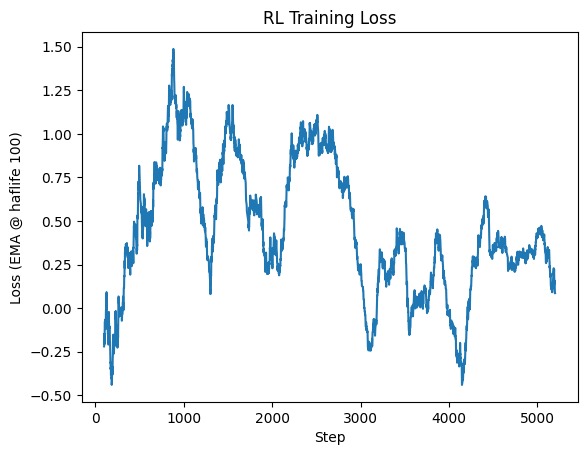

In [ ]:
pd.Series(all_losses).ewm(halflife=100, min_periods=100).mean().plot()
plt.xlabel("Step")
plt.ylabel("Loss (EMA @ haflife 100)")
plt.title("RL Training Loss")
plt.show()

### 3.3 Evaluate RL Policy

In [ ]:
## Run eval loop with fine-tuned model
rl_episodes = {"rl": []}
num_episodes_per_agent = 20

# model_lora = peft.PeftModel.from_pretrained(model, f"{target_dir}/rl_lora")
for ep in range(num_episodes_per_agent):
    printmd(f"#### Episode {ep}")
    memory, data, total_reward = episode_rollout(model_lora, gameFold="test",  seed=ep * 123)
    rl_episodes['rl'].append({"ep": ep, "total_reward": total_reward, "memory": memory, "data": data})

## save results
with open(f"{target_dir}/episodes_rl_agent.json", "w") as f:
    json.dump(rl_episodes, f)

## print an episode
printmd('\n\n'.join(rl_episodes['rl'][0]['memory']))

#### Episode 0

Episode Progress: 0it [00:00, ?it/s]

#### Episode 1

Episode Progress: 0it [00:00, ?it/s]

#### Episode 2

Episode Progress: 0it [00:00, ?it/s]

#### Episode 3

Episode Progress: 0it [00:00, ?it/s]

#### Episode 4

Episode Progress: 0it [00:00, ?it/s]

#### Episode 5

Episode Progress: 0it [00:00, ?it/s]

#### Episode 6

Episode Progress: 0it [00:00, ?it/s]

#### Episode 7

Episode Progress: 0it [00:00, ?it/s]

#### Episode 8

Episode Progress: 0it [00:00, ?it/s]

#### Episode 9

Episode Progress: 0it [00:00, ?it/s]

#### Episode 10

Episode Progress: 0it [00:00, ?it/s]

#### Episode 11

Episode Progress: 0it [00:00, ?it/s]

#### Episode 12

Episode Progress: 0it [00:00, ?it/s]

#### Episode 13

Episode Progress: 0it [00:00, ?it/s]

#### Episode 14

Episode Progress: 0it [00:00, ?it/s]

#### Episode 15

Episode Progress: 0it [00:00, ?it/s]

#### Episode 16

Episode Progress: 0it [00:00, ?it/s]

#### Episode 17

Episode Progress: 0it [00:00, ?it/s]

#### Episode 18

Episode Progress: 0it [00:00, ?it/s]

#### Episode 19

Episode Progress: 0it [00:00, ?it/s]

`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.

`[Starting Obs]`: You are in the kitchen. In one part of the room you see a stove. There is also an oven. You also see a fridge that is closed. In another part of the room you see a counter, that has nothing on it. In one part of the room you see a kitchen cupboard that is closed. There is also a cutlery drawer that is closed. You also see a trash can that is closed. In another part of the room you see a dishwasher that is closed. In one part of the room you see a dining chair, that has nothing on it. There is also a newspaper. You also see a dirty mesh skimmer. 
To the West you see the living room. 

###  `Action step 1`

`[Time]` 10:32:55

`[Valid Actions]`: ['open kitchen cupboard', 'take newspaper', 'take dirty mesh skimmer', 'open trash can', 'open fridge', 'open cutlery drawer', 'move west', 'inventory', 'open dishwasher', 'look around']

`[Action]`: inventory

`[Reward]`: 0.00

`[Obs]`: Inventory: 
  Your inventory is currently empty.


###  `Action step 2`

`[Time]` 10:32:55

`[Valid Actions]`: ['open dishwasher', 'take newspaper', 'inventory', 'open fridge', 'open trash can', 'take dirty mesh skimmer', 'look around', 'move west', 'open cutlery drawer', 'open kitchen cupboard']

`[Action]`: take newspaper

`[Reward]`: 0.12

`[Obs]`: You take the newspaper.

###  `Action step 3`

`[Time]` 10:32:55

`[Valid Actions]`: ['inventory', 'open trash can', 'put newspaper in dining chair', 'take dirty mesh skimmer', 'open dishwasher', 'open cutlery drawer', 'open fridge', 'move west', 'open kitchen cupboard', 'look around', 'put newspaper in counter']

`[Action]`: take dirty mesh skimmer

`[Reward]`: 0.12

`[Obs]`: You take the dirty mesh skimmer.

###  `Action step 4`

`[Time]` 10:32:55

`[Valid Actions]`: ['open trash can', 'open fridge', 'put dirty mesh skimmer in counter', 'inventory', 'put newspaper in dining chair', 'put newspaper in counter', 'open dishwasher', 'put dirty mesh skimmer in dining chair', 'move west', 'open cutlery drawer', 'open kitchen cupboard', 'look around']

`[Action]`: open fridge

`[Reward]`: 0.00

`[Obs]`: You open the fridge. It's empty inside.

###  `Action step 5`

`[Time]` 10:32:55

`[Valid Actions]`: ['open trash can', 'close fridge', 'put newspaper in fridge', 'put newspaper in counter', 'move west', 'open kitchen cupboard', 'put dirty mesh skimmer in counter', 'put dirty mesh skimmer in fridge', 'put newspaper in dining chair', 'look around', 'put dirty mesh skimmer in dining chair', 'open dishwasher', 'open cutlery drawer', 'inventory']

`[Action]`: open dishwasher

`[Reward]`: 0.00

`[Obs]`: You open the dishwasher. It's empty inside.

###  `Action step 6`

`[Time]` 10:32:55

`[Valid Actions]`: ['put dirty mesh skimmer in dishwasher', 'put dirty mesh skimmer in counter', 'look around', 'move west', 'put newspaper in counter', 'put dirty mesh skimmer in fridge', 'open cutlery drawer', 'put dirty mesh skimmer in dining chair', 'close dishwasher', 'close fridge', 'put newspaper in dishwasher', 'open kitchen cupboard', 'inventory', 'put newspaper in dining chair', 'open trash can', 'put newspaper in fridge']

`[Action]`: put newspaper in fridge

`[Reward]`: -0.12

`[Obs]`: You put the newspaper in the fridge.

###  `Action step 7`

`[Time]` 10:32:56

`[Valid Actions]`: ['put dirty mesh skimmer in dining chair', 'open cutlery drawer', 'put dirty mesh skimmer in fridge', 'inventory', 'put dirty mesh skimmer in dishwasher', 'move west', 'close fridge', 'look around', 'take newspaper', 'close dishwasher', 'open trash can', 'put dirty mesh skimmer in counter', 'open kitchen cupboard']

`[Action]`: put dirty mesh skimmer in dining chair

`[Reward]`: -0.12

`[Obs]`: You put the dirty mesh skimmer in the dining chair.

###  `Action step 8`

`[Time]` 10:32:56

`[Valid Actions]`: ['open cutlery drawer', 'close fridge', 'close dishwasher', 'take newspaper', 'take dirty mesh skimmer', 'inventory', 'move west', 'open kitchen cupboard', 'open trash can', 'look around']

`[Action]`: take newspaper

`[Reward]`: 0.12

`[Obs]`: You take the newspaper.

###  `Action step 9`

`[Time]` 10:32:56

`[Valid Actions]`: ['put newspaper in counter', 'open cutlery drawer', 'open trash can', 'close dishwasher', 'move west', 'put newspaper in dishwasher', 'put newspaper in dining chair', 'take dirty mesh skimmer', 'close fridge', 'look around', 'open kitchen cupboard', 'inventory', 'put newspaper in fridge']

`[Action]`: put newspaper in fridge

`[Reward]`: -0.12

`[Obs]`: You put the newspaper in the fridge.

###  `Action step 10`

`[Time]` 10:32:57

`[Valid Actions]`: ['inventory', 'take newspaper', 'open kitchen cupboard', 'close dishwasher', 'move west', 'open trash can', 'close fridge', 'take dirty mesh skimmer', 'look around', 'open cutlery drawer']

`[Action]`: take newspaper

`[Reward]`: 0.12

`[Obs]`: You take the newspaper.

###  `Action step 11`

`[Time]` 10:32:57

`[Valid Actions]`: ['open trash can', 'open kitchen cupboard', 'close fridge', 'open cutlery drawer', 'inventory', 'look around', 'move west', 'put newspaper in fridge', 'put newspaper in dishwasher', 'take dirty mesh skimmer', 'close dishwasher', 'put newspaper in counter', 'put newspaper in dining chair']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. In one part of the room you see a can opener. There is also a milk. 
To the East you see the kitchen. To the West you see a closed wood door. 

###  `Action step 12`

`[Time]` 10:32:57

`[Valid Actions]`: ['look around', 'open wastepaper basket', 'put newspaper in coffee table', 'put newspaper in side table', 'put newspaper in arm chair', 'put newspaper in end table', 'take can opener', 'put newspaper in TV stand', 'open door to west', 'move east', 'put newspaper in book case', 'take milk', 'inventory', 'put newspaper in sofa', 'close door to west', 'move west']

`[Action]`: open wastepaper basket

`[Reward]`: 0.00

`[Obs]`: You open the wastepaper basket. It's empty inside.

###  `Action step 13`

`[Time]` 10:32:58

`[Valid Actions]`: ['put newspaper in book case', 'put newspaper in end table', 'take milk', 'put newspaper in sofa', 'take can opener', 'close door to west', 'move east', 'look around', 'inventory', 'move west', 'close wastepaper basket', 'put newspaper in arm chair', 'put newspaper in TV stand', 'put newspaper in side table', 'open door to west', 'put newspaper in wastepaper basket', 'put newspaper in coffee table']

`[Action]`: close door to west

`[Reward]`: 0.00

`[Obs]`: That is already closed. 

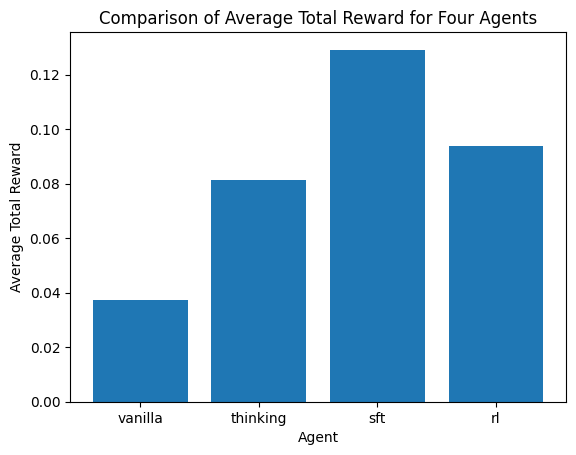

In [ ]:
all_eps = baseline_episodes | sft_episodes | rl_episodes

avg_rewards = {
    a: np.mean([ep["total_reward"] for ep in all_eps[a]])
    for a in ["vanilla", "thinking", "sft", "rl"]
}

# make a bar chart
agents = list(avg_rewards.keys())
rewards = list(avg_rewards.values())

plt.bar(agents, rewards)
plt.xlabel("Agent")
plt.ylabel("Average Total Reward")
plt.title("Comparison of Average Total Reward for Four Agents")
plt.show()

### 3.4 RL Results

* Do not be discouraged if RL did not beat SFT
expected to beat the other baselines.
* 🤔 **Training RL is notoriously hard and we did not implement many techniques of the RL literature!** 😭
* In fact, we implemented the most vanilla possible version of RL. One that is used only for toy examples.
* 🤩 And yet, **we only trained for a few minutes, we were able to improve over chain of thought agent at 5x the generation speed!** ⏩
* 🫵🏻 I challenge you to apply state-of-the-art RL to this problem! 🚅

# Conclusion: 🤗 What did we learn? 🤔

* 🌎 While prompting techniques are powerful, sometimes we need to ground our agent in a specific task by finetuning the neural network weights of the LLM.
* 🏰 LLMs are to big to be finetuned in the usual way. We need parameter efficient finetuning techniques such as LORA.
* 🧮 A little expert labeled data will go a long long way, even to finetune models with billions of parameters --> SFT
* 🐕 When no expert data is available, RL comes to the rescue!

<br>
<img src="https://drive.google.com/uc?export=view&id=1BCv4CkAcwl07yUBEmXcZANmUASPlyyYl" alt="drawing" width="600"/>
